In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scienceplots
from models.HH import *
from models.LIF import * 
from models.Ishikevich import *
from models.morrislecar import *
from utils.load import *
from utils.compue_chi import *
from utils.compute_van_Rossum_distance import *
import matplotlib.animation as animation
from scipy.sparse import dok_matrix
from matplotlib import rc 

In [2]:
plt.style.use('science')
plt.rcParams["figure.figsize"] = (12,7)

#### Setting up the experiment

We are starting with a fixed random seed, an intensity like the one in experiment 6, and a high enough time to obtain at least 100 peaks

In [3]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 7000
dt = 0.01

#fixing random seed
np.random.seed(1234)

#generating the intensity
I = np.zeros((int(t_final/dt),2))

x1 = np.random.normal(0,5,int(t_final/dt))
x2 = np.random.normal(0,5,int(t_final/dt))

I[:,0] = 2 + 5*x1
I[:,1] = 1.5 + 5*x2 


Let's see if the simulation works

In [4]:
#HH
Isyn = np.zeros(([2 , 2 ]))
tau = 0.3
V0 = -60
n0 = 0.2 
m0 = 0.1 
h0 = 0.6 
order = 5
k = 0.012
data_HH, completeHH, matrix_HH = rk_simplemodel_Rossum(dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I,Isyn,k,tau)


In [5]:
#LIF
Is = np.array([ [0, 0.05], [0.05, 0]])
tau = 0.65
y0 = [-60, -60]
data_IF, completeIF, matrix_IF = rk_if_Rossum(dt, t_final,order,y0,*params_LIF,I,Is,k,tau,0.7)

In [6]:
#IZH
Is = np.array([ [0, 0.05], [0.05, 0]])
tau = 0.65
y0 = [-60, -60]
u0 = [0,0]
k_izh = 0.04
data_Ish, completeIsh, matrix_Ish = rk_ish_Rossum(dt,t_final,order,y0,u0,I,Is,*params_IZH,k_izh,tau)


In [7]:
#ML
k_ML = 0.008
Is = np.array([ [0, 0.05], [0.05, 0]])
tau = 0.65
y0 = [-60 , -60]
w0 = [0.0007223855976593603, 0.0007223855976593603]
data_ML, completeML, matrix_ML = rk_ml_Rossum(dt,t_final,2,y0,w0,*params_ML,I,Isyn,k_ML,tau)

In [8]:
print(np.argwhere(np.array(matrix_HH.todense())[0,:] > 0))

[[  1505]
 [  1507]
 [  1517]
 ...
 [697964]
 [697968]
 [697972]]


In [9]:
spike_HH_1 =  (np.argwhere(np.array(matrix_HH.todense())[0,:]>0) * dt).flatten()
spike_HH_2 =  (np.argwhere(np.array(matrix_HH.todense())[1,:]>0) * dt).flatten()
spike_IF_1 =  (np.argwhere(np.array(matrix_IF.todense())[0,:]>0) * dt).flatten()
spike_IF_2 =  (np.argwhere(np.array(matrix_IF.todense())[1,:]>0) * dt).flatten()
spike_Ish_1 =  (np.argwhere(np.array(matrix_Ish.todense())[0,:]>0) * dt).flatten()
spike_Ish_2 = (np.argwhere(np.array(matrix_Ish.todense())[1,:]>0) * dt).flatten()
spike_ML_1 = (np.argwhere(np.array(matrix_ML.todense())[0,:]>0) * dt).flatten()
spike_ML_2 = (np.argwhere(np.array(matrix_ML.todense())[1,:]>0) * dt).flatten()

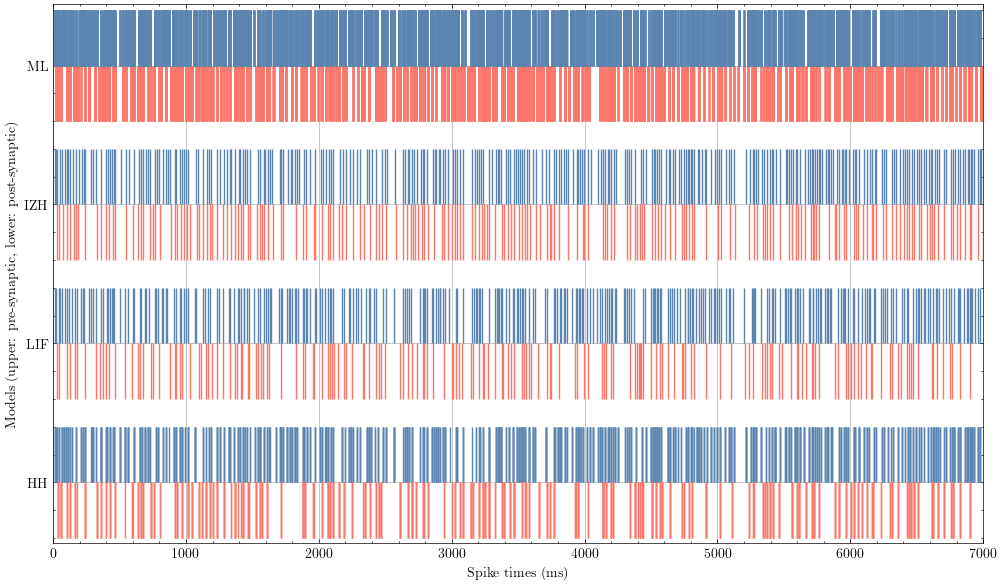

In [10]:
fig, ax = plt.subplots()

ax.eventplot(spike_HH_1, color = '#5B84B1FF')
ax.eventplot(spike_HH_2,color='#FC766AFF',lineoffsets=0,label='hola')
ax.eventplot(spike_IF_2,color = '#FC766AFF',lineoffsets=2.5)
ax.eventplot(spike_IF_1, color = '#5B84B1FF', lineoffsets= 3.5)
ax.eventplot(spike_Ish_2,color = '#FC766AFF',lineoffsets= 5.0 )
ax.eventplot(spike_Ish_1, color = '#5B84B1FF', lineoffsets= 6.0)
ax.eventplot(spike_ML_2, color = '#FC766AFF', lineoffsets= 7.5)
ax.eventplot(spike_ML_1,color = '#5B84B1FF', lineoffsets= 8.5)
ax.grid()
ax.set_ylim(-0.6,9.1)
ax.set_ylabel('Models (upper: pre-synaptic, lower: post-synaptic)')
plt.yticks((0.5,3.0,5.5,8.0))
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'HH'
labels[1] = 'LIF'
labels[2] = 'IZH'
labels[3] = 'ML'

ax.set_yticklabels(labels, color = 'black')
ax.set_xlabel('Spike times (ms)')
ax.set_xlim(0,7000)

plt.show()


#### Synchrony measurements

##### 1.- Peaks in mean voltage
Compute average voltage.

Find peaks in average voltage

Count the number of peaks

(How to count peaks in models that are not the LIF)

##### 2.- Chi measure (function)

In [11]:
chi_HH = compute_chi(data_HH)
chi_LIF = compute_chi(data_IF)
chi_IZH = compute_chi(data_Ish)
chi_ML = compute_chi(data_ML)

In [12]:
print(' chi_HH:', chi_HH, '\n chi_LIF:' ,chi_LIF,'\n chi_IZH:', chi_IZH, '\n chi_ML:' ,chi_ML)

 chi_HH: 0.49780525181586205 
 chi_LIF: 0.49739497919430314 
 chi_IZH: 0.5472571345059186 
 chi_ML: 0.5124645290685675


##### 3.- Van Rossum distance (function)
Obtain the spike matrix 

Find average van Rossum distance

Normslise it by firing reate (also obtained through the spike matrix)

In [13]:
t = np.linspace(0,t_final,int(t_final/dt))
van_Rossum_HH = compute_van_Rossum_distance(matrix_HH,t,10)
van_Rossum_IF = compute_van_Rossum_distance(matrix_IF,t,10)
van_Rossum_IZH = compute_van_Rossum_distance(matrix_Ish,t,10)
van_Rossum_ML = compute_van_Rossum_distance(matrix_ML,t,10)

In [14]:
print(van_Rossum_HH,'\n', van_Rossum_IF,'\n', van_Rossum_IZH,'\n', van_Rossum_ML)

[[ 0.        14.3700901]
 [14.3700901  0.       ]] 
 [[0.         3.68295886]
 [3.68295886 0.        ]] 
 [[ 0.         10.23563867]
 [10.23563867  0.        ]] 
 [[0.         8.02961794]
 [8.02961794 0.        ]]


In [15]:
num_neurons_HH = np.argwhere(matrix_HH>0)
num_neurons_IF = np.argwhere(matrix_IF>0)
num_neurons_IZh = np.argwhere(matrix_Ish>0)
num_neurons_ML = np.argwhere(matrix_ML>0)

In [16]:
firing_rate_HH = len(num_neurons_HH) / 2 * 1000/t_final
firing_rate_IF = len(num_neurons_IF) / 2 * 1000/t_final
firing_rate_Izh = len(num_neurons_IZh) / 2 * 1000/t_final
firing_rate_ML = len(num_neurons_ML) / 2 * 1000/t_final

In [17]:
print(van_Rossum_HH/firing_rate_HH, '\n', van_Rossum_IF/firing_rate_IF, '\n', van_Rossum_IZH/firing_rate_Izh, '\n', van_Rossum_ML/firing_rate_ML)

[[0.        0.1270886]
 [0.1270886 0.       ]] 
 [[0.         0.09992524]
 [0.09992524 0.        ]] 
 [[0.         0.26685092]
 [0.26685092 0.        ]] 
 [[0.         0.01285473]
 [0.01285473 0.        ]]


#### Signals in prefect synchrony, and in perfect a-synchrony?

In [18]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 7000
dt = 0.01

#fixing random seed
np.random.seed(1234)

#generating the intensity
I = np.zeros((int(t_final/dt),2))

x1 = np.random.normal(0,5,int(t_final/dt))
x2 = np.random.normal(0,5,int(t_final/dt))

I[:,0] = 2.37


In [19]:
#HH
Isyn = np.zeros(([2 , 2 ]))
tau = 0.3
V0 = -60
n0 = 0.2 
m0 = 0.1 
h0 = 0.6 
order = 5
k = 0.012
data_HH, completeHH, matrix_HH = rk_simplemodel_Rossum(dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I,Isyn,0,tau)


In [20]:
#LIF
Is = np.array([ [0, 0.05], [0.05, 0]])
tau = 0.65
y0 = [-60, -60]
data_IF, completeIF, matrix_IF = rk_if_Rossum(dt, t_final,order,y0,*params_LIF,I,Is,0,tau,0.7)

In [21]:
#IZH
Is = np.array([ [0, 0.05], [0.05, 0]])
tau = 0.65
y0 = [-60, -60]
u0 = [0,0]
k_izh = 0.04
data_Ish, completeIsh, matrix_Ish = rk_ish_Rossum(dt,t_final,order,y0,u0,I,Is,*params_IZH,0,tau)

In [22]:
#ML
k_ML = 0.008
Is = np.array([ [0, 0.05], [0.05, 0]])
tau = 0.65
y0 = [-60 , -60]
w0 = [0.0007223855976593603, 0.0007223855976593603]
data_ML, completeML, matrix_ML = rk_ml_Rossum(dt,t_final,2,y0,w0,*params_ML,I,Isyn,0,tau)

In [23]:
chi_HH = compute_chi(data_HH)
chi_LIF = compute_chi(data_IF)
chi_IZH = compute_chi(data_Ish)
chi_ML = compute_chi(data_ML)

In [24]:
print(' chi_HH:', chi_HH, '\n chi_LIF:' ,chi_LIF,'\n chi_IZH:', chi_IZH, '\n chi_ML:' ,chi_ML)

 chi_HH: 0.35355699796751666 
 chi_LIF: 0.3310905919461409 
 chi_IZH: 0.3537851470560457 
 chi_ML: 0.3535941347658501


In [25]:
t = np.linspace(0,t_final,int(t_final/dt))
van_Rossum_HH = compute_van_Rossum_distance(matrix_HH,t,10)
van_Rossum_IF = compute_van_Rossum_distance(matrix_IF,t,10)
van_Rossum_IZH = compute_van_Rossum_distance(matrix_Ish,t,10)
van_Rossum_ML = compute_van_Rossum_distance(matrix_ML,t,10)

In [26]:
print(van_Rossum_HH,'\n', van_Rossum_IF,'\n', van_Rossum_IZH,'\n', van_Rossum_ML)

[[ 0.         29.03399519]
 [29.03399519  0.        ]] 
 [[ 0.         22.11369126]
 [22.11369126  0.        ]] 
 [[ 0.         26.91424594]
 [26.91424594  0.        ]] 
 [[0.        8.5166249]
 [8.5166249 0.       ]]


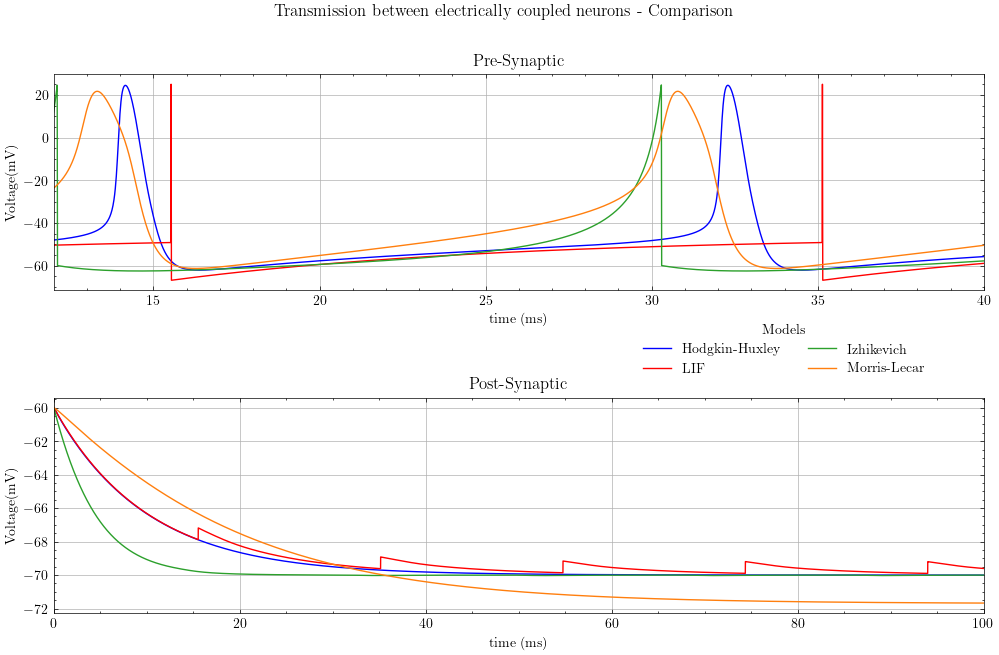

In [27]:
time = np.linspace(0,t_final,int(t_final/dt))

fig, (ax1, ax2) = plt.subplots(2,1) 

fig.subplots_adjust(hspace=0.5)
ax1.set_xlabel('time (ms)')
ax2.set_xlabel('time (ms)')

ax1.set_ylabel('Voltage(mV)')
ax2.set_ylabel('Voltage(mV)')

ax1.set_xlim(12,40)
ax2.set_xlim(0,100)


plt.suptitle('Transmission between electrically coupled neurons - Comparison')

ax1.title.set_text('Pre-Synaptic')
ax1.plot(time,data_HH[:,0], color = 'b', label = 'HH')
ax1.plot(time,data_IF[:,0], color = 'r', label = 'LIF')
ax1.plot(time,data_Ish[:,0], color = 'tab:green', label = 'Izhikevich')
ax1.plot(time,data_ML[:,0], color = 'tab:orange', label = 'Morris-Lecar' )

ax2.title.set_text('Post-Synaptic')

ax2.plot(time,data_HH[:,1], label = 'Hodgkin-Huxley', color = 'b')
ax2.plot(time,data_IF[:,1], label =' LIF', color= 'red')
ax2.plot(time,data_Ish[:,1], color = 'tab:green', label = 'Izhikevich')
ax2.plot(time,data_ML[:,1], color = 'tab:orange', label = 'Morris-Lecar')



ax2.legend(title = 'Models',bbox_to_anchor=(0.95, 1.4),ncols=2)
ax1.grid()
ax2.grid()

plt.show()

In [28]:
data_test = data_HH
data_test[:,1] = data_HH[:,0]
matrix_test = matrix_HH
matrix_test[1,:] = matrix_HH[0,:]

a = data_HH[900:len(data_HH)-1,0]
b = data_HH[0:len(data_HH)-1-900,0]

data_test_tempered = np.vstack((a,b)).T

a = matrix_HH[0,900:len(data_HH)-1].todense()
b = matrix_HH[0,0:len(data_HH)-1-900].todense()

matrix_test_tempered = np.array(np.vstack((a,b)))


(0.0, 6000.0)

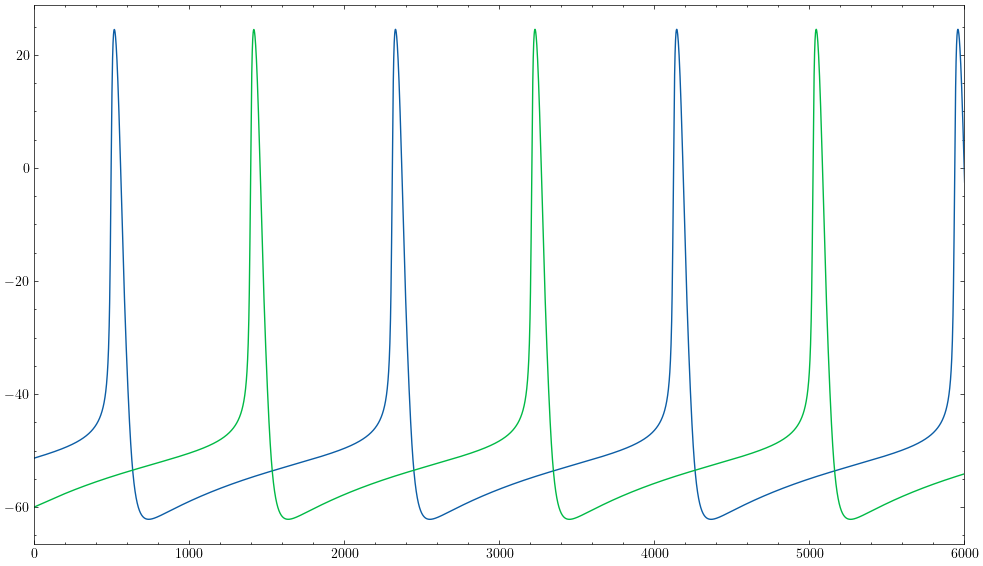

In [29]:
plt.plot(data_test_tempered[:,0])
plt.plot(data_test_tempered[:,1])
plt.xlim(0,6000)

In [30]:
np.shape(data_test_tempered)
#np.shape(data_test)

(699099, 2)

In [31]:
chi_test = compute_chi(data_test)
chi_test_bad = compute_chi(data_test_tempered)

In [32]:
print(chi_test,chi_test_bad)

0.9999999999991894 0.43952577609195337


In [33]:
import numpy as np 
from scipy.sparse import dok_matrix

def compute_van_Rossum_distance(spike_matrix,t,t_R):
    '''
    Computes the van Rossum distance between a set of spike trains
    spike matrix - matrix containing spike train, each row corresponds to
    different neuron/spike train
    t - time vector (time points for columns of spike_matrix)
    t_R - time constant of exponential kernel
    '''
    dt = (t[len(t)-1] - t[0] ) / (len(t)-1)

    if type(spike_matrix) is not np.ndarray:
        spike_matrix = np.array(spike_matrix.todense())
    N = len(spike_matrix[:,0])  
    van_Rossum = np.zeros((N,N))
    waveforms = np.zeros_like(spike_matrix)
    #construct kernel
    print('hola2')
    kernel = np.exp(-t/t_R)
    print('hola3')
    #Convolve spike trains with kernel
    # (2D convolution iwth 1 as column convolution, i.e. no convolution)
    for j in range(0,N):
        print('hola')
        print(np.shape(np.convolve(spike_matrix[j,:], kernel, 'valid') ), np.shape(waveforms[j,:]))
        print('adios')
        waveforms[j,:] = np.convolve(spike_matrix[j,:], kernel, 'valid') 
    
    #compute van Rossum distance between each pair of spike trains
    for j in range(0,N):
        waveform_difference = waveforms - waveforms[j,:]
        van_Rossum[j,:] = np.sqrt(np.trapz(waveform_difference**2/t_R,dx=dt))
    return van_Rossum    


In [34]:
t = np.linspace(0,t_final,int(t_final/dt))
t_2 = np.linspace(0,699099,int(699099/dt))
van_Rossum_test = compute_van_Rossum_distance(matrix_test,t,10)
van_Rossum_test_bad =compute_van_Rossum_distance(matrix_test_tempered,t_2,10)

hola2
hola3
hola
(1,) (700000,)
adios
hola
(1,) (700000,)
adios
hola2
hola3
hola


In [35]:
print(van_Rossum_test)
print(van_Rossum_test_bad)

array([[0., 0.],
       [0., 0.]])